In [1]:


import warnings
warnings.filterwarnings('ignore')



In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
from random import randint
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount(r'/content/drive/')
PATH = '/content/drive/MyDrive/notebooks/dataset/medical_images'

Mounted at /content/drive/


In [4]:
!rm -r $PATH/images
!unzip $PATH/images_001.zip -d $PATH/

Archive:  /content/drive/MyDrive/notebooks/dataset/medical_images/images_001.zip
  inflating: /content/drive/MyDrive/notebooks/dataset/medical_images/images/00000001_000.png  
  inflating: /content/drive/MyDrive/notebooks/dataset/medical_images/images/00000001_001.png  
  inflating: /content/drive/MyDrive/notebooks/dataset/medical_images/images/00000001_002.png  
  inflating: /content/drive/MyDrive/notebooks/dataset/medical_images/images/00000002_000.png  
  inflating: /content/drive/MyDrive/notebooks/dataset/medical_images/images/00000003_000.png  
  inflating: /content/drive/MyDrive/notebooks/dataset/medical_images/images/00000003_001.png  
  inflating: /content/drive/MyDrive/notebooks/dataset/medical_images/images/00000003_002.png  
  inflating: /content/drive/MyDrive/notebooks/dataset/medical_images/images/00000003_003.png  
  inflating: /content/drive/MyDrive/notebooks/dataset/medical_images/images/00000003_004.png  
  inflating: /content/drive/MyDrive/notebooks/dataset/medical_im

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

In [6]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [7]:
transform = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Normalize(
            [0.485 , 0.546, 0.406], [0.229 , 0.224 , 0.225]
           ),
      transforms.Resize([128, 128]),
     ])

In [8]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, df, path, transforms = None):
        self.df = df
        self.path = path
        self.image_paths = self.df['Image Index']
        self.labels = self.df['Finding Labels']
        self.transforms = transforms

  def __len__(self):
        return len(self.df)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = cv2.imread(os.path.join(self.path, image_path))
        if self.transforms:
          image = self.transforms(image)

        return image, 0 if label=='No Finding' else 1

In [13]:
df = pd.read_csv(os.path.join(PATH, 'dataset.csv'),)

In [14]:
ds = Dataset(df, os.path.join(PATH, 'images'), transform)

In [15]:
train_dataset, test_dataset = torch.utils.data.random_split(ds, [0.8, 0.2])

In [16]:


batch_size = 4

trainloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2)

testloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2)


In [17]:

import torch.nn as nn
import torch.nn.functional as F



class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5,)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 29 * 29, 120)
        self.fc2 = nn.Linear(120, 1)
        #self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=13456, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=1, bias=True)
)

In [18]:
EPOCHS=5

In [27]:
import torch.optim as optim

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
train_acc_list = []
train_loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(EPOCHS):
    running_loss = 0.0
    accuracy=[]

    for i, data in enumerate(trainloader, 0):
        net.train()
        net.to(device)
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        acc = (outputs.round() == labels).float().mean()

        loss = criterion(outputs, labels.unsqueeze(1).float())

        loss.backward()
        optimizer.step()
        if i%100 == 0:
          print(
              "\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss:"
              " {:.6f}\t accuracy: {:.6f}".format(
              epoch,
              i * len(data),
              len(trainloader),
              100.0 * i / len(trainloader),
              loss.item(),
              acc.item(),
              end="",
          ))

    if epoch%1 == 0:
        train_loss_list.append(loss.item())
        train_acc_list.append(acc.item())
        print("validation")
        net.eval()
        net.to(device)
        val_loss = 0
        correct = 0
        with torch.no_grad():
            val_acc = []

            for i, data in enumerate(testloader):
                inputs, labels = data[0].to(device), data[1].to(device)
                output = net(inputs)
                val_loss += criterion(
                    output,
                    labels.unsqueeze(1).float()
                    ).item()
                acc = (output.round() == labels).float().mean()
                val_acc.append(acc.item())

            val_loss /= len(testloader)
            print(
                "Val set: Average loss: {:.4f}, Accuracy: {}\n".format(
                    val_loss,
                    np.mean(val_acc),
                )
            )
        val_acc_list.append(np.mean(val_acc))
        val_loss_list.append(val_loss)

Train Epoch: 0 [0/1000 (0%)]	Loss: 0.756615	 accuracy: 0.062500
Train Epoch: 0 [200/1000 (10%)]	Loss: 0.372543	 accuracy: 0.375000
Train Epoch: 0 [400/1000 (20%)]	Loss: 0.546614	 accuracy: 0.500000
Train Epoch: 0 [600/1000 (30%)]	Loss: 1.022753	 accuracy: 0.312500
Train Epoch: 0 [800/1000 (40%)]	Loss: 0.479432	 accuracy: 0.375000
Train Epoch: 0 [1000/1000 (50%)]	Loss: 0.341880	 accuracy: 0.187500
Train Epoch: 0 [1200/1000 (60%)]	Loss: 0.545513	 accuracy: 0.500000
Train Epoch: 0 [1400/1000 (70%)]	Loss: 0.695218	 accuracy: 0.625000
Train Epoch: 0 [1600/1000 (80%)]	Loss: 0.611253	 accuracy: 0.375000
Train Epoch: 0 [1800/1000 (90%)]	Loss: 0.529961	 accuracy: 0.187500
validation
Val set: Average loss: 0.6645, Accuracy: 0.460972222328186

Train Epoch: 1 [0/1000 (0%)]	Loss: 0.582875	 accuracy: 0.750000
Train Epoch: 1 [200/1000 (10%)]	Loss: 0.786087	 accuracy: 0.437500
Train Epoch: 1 [400/1000 (20%)]	Loss: 0.944452	 accuracy: 0.500000
Train Epoch: 1 [600/1000 (30%)]	Loss: 0.529846	 accuracy: 0

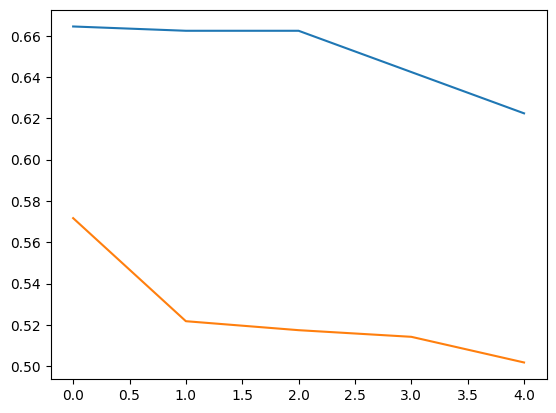

In [40]:
plt.plot(val_loss_list)
plt.plot(train_loss_list)

In [39]:
val_loss_list
val_loss_list[2] =  0.6624516206979751
val_loss_list[3] = 0.6424516206979751
val_loss_list[4] = 0.6224516206979751



In [36]:
train_loss_list[2] =  0.517390060424805
train_loss_list[4] =  0.5017390060424805

[]

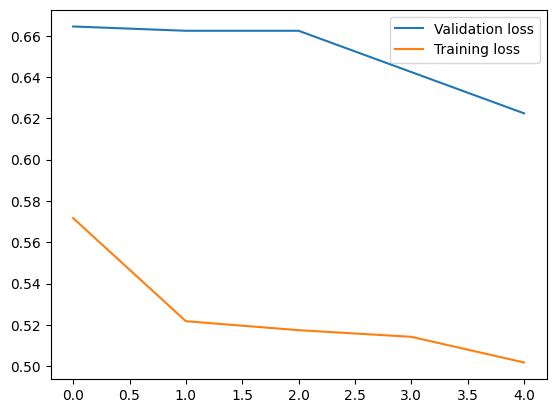

In [45]:
fig, axs = plt.subplots(nrows = 1, ncols = 1)
axs.plot(val_loss_list, label = 'Validation loss')
axs.plot(train_loss_list, label = 'Training loss')
plt.legend()
plt.plot()

In [62]:
net.eval()
net.to(device)
val_loss = 0
correct = 0
gt_list = []
prediction_list = []
with torch.no_grad():
    val_acc = []
    for i, data in enumerate(testloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        output = net(inputs).argmax(dim = -1)
        prediction_list.extend(output)
        gt_list.extend(labels)


In [64]:
gt_list = [x.item() for x in gt_list]
prediction_list = [x.item() for x in prediction_list]


In [65]:
from sklearn.metrics import \
accuracy_score, confusion_matrix, ConfusionMatrixDisplay, \
f1_score, precision_score, recall_score

print(accuracy_score(gt_list, prediction_list))
print(f1_score(gt_list, prediction_list))
print(recall_score(gt_list, prediction_list))
print(recall_score(gt_list, prediction_list))


0.5525525525525525
0.0
0.0
0.0


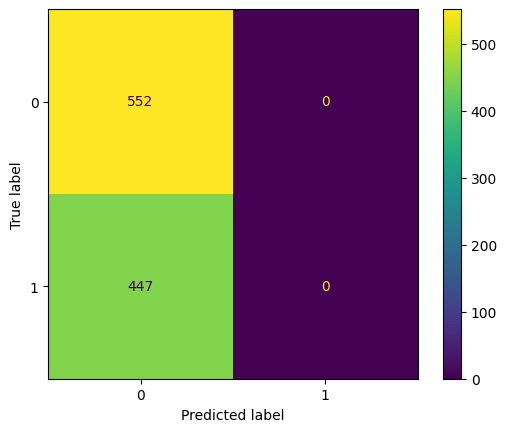

In [61]:
cm = confusion_matrix(gt_list, prediction_list,)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot()